# Weather GAN Results

good model checkpoints:

- /home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/last.ckpt



In [1]:
%load_ext autoreload
%autoreload 2
#%cd /home/ftei-dsw/projects/weather-gan
%cd /home/hess/projects/weather-gan

/home/hess/projects/weather-gan


In [2]:
import torch
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from src.model import Generator, Discriminator
from src.data import Transforms
from src.inference import Inference
from src.plots import plot_sample, plot_histograms

In [3]:
#checkpoint_path = '/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/'
#checkpoint_path = '/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/16h_29m_18/1bfcabc2-b67f-11ec-883b-845cf3c98452/last.ckpt'
#checkpoint_path = '/home/ftei-dsw/data/weather-gan/checkpoints/weather-gan/11h_16m_27/b9727056-c153-11ec-9f71-845cf3c98452/last.ckpt'
checkpoint_path = '/p/tmp/hess/scratch/weather-gan/checkpoints/weather-gan/2022_04_28/32ee0922-c6d1-11ec-b03f-40f2e9c534b2/last.ckpt'
inference = Inference(checkpoint_path, epoch_index=None)

In [4]:
gan = inference.run()
data = inference.get_target_and_input()
target = data['target']
input = data['input']

Checkpoint 1 / 1:
/p/tmp/hess/scratch/weather-gan/checkpoints/weather-gan/2022_04_28/32ee0922-c6d1-11ec-b03f-40f2e9c534b2/last.ckpt

number of threads 2
Start inference:


  0%|          | 0/182 [00:00<?, ?it/s]

number of threads 2


  0%|          | 0/182 [00:00<?, ?it/s]

In [6]:
def sample(inference: Inference, noise: torch.Tensor):

    generator = inference.generator
    transforms = inference.transforms

    z = noise.type_as(input)
    x = torch.cat([input, z], dim=1)
    yhat = generator(x.cuda())
    yhat = yhat.cpu()
    yhat = transforms.inverse_normalize(yhat)
    yhat = transforms.inverse_log(yhat)
    yhat = yhat*24*3600
    
    return yhat


latent_dim = 6


z_init = torch.randn(input.shape[0], latent_dim, input.shape[2],  input.shape[3])
z_final = torch.randn(input.shape[0], latent_dim, input.shape[2],  input.shape[3])


yhat_init = sample(inference, z_init)
yhat_final = sample(inference, z_final)
n_steps = 4
eps = 1./n_steps
yhat_inter_list = []
for i in range(n_steps):
    if i > 0:
        z_init = z_inter
    incr = (z_final-z_init)*eps
    z_inter = z_init+incr
    yhat_inter = sample(inference, z_inter)
    yhat_inter_list.append(yhat_inter)


In [7]:
def corr(x, y):
    from scipy import stats
    #result = np.correlate(x.flatten(), y.flatten(), mode='full')
    result = stats.spearmanr(x.flatten(), y.flatten())[0]
    return result.mean()

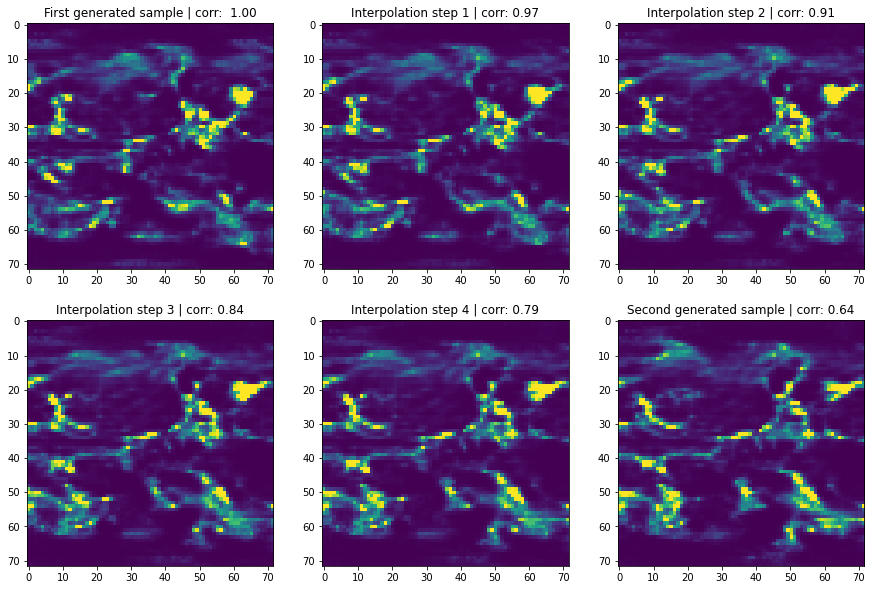

In [9]:
n_col = 2
n_row = int((2 + n_steps)//2)
vmax = 20

plt.figure(figsize=(15,10))

plt.subplot(n_col,n_row,1)
plt.imshow(yhat_init[0,0], vmax=vmax)
correlation = corr(yhat_init[0,0], yhat_init[0,0])
plt.title(f"First generated sample | corr: {correlation: 2.2f}")

for i in range(n_steps):
    correlation = corr(yhat_init[0,0], yhat_inter_list[i][0,0])
    plt.subplot(n_col,n_row,2+i)
    plt.imshow(yhat_inter_list[i][0,0], vmax=vmax)
    plt.title(f"Interpolation step {i+1} | corr: {correlation :2.2f}")

plt.subplot(n_col,n_row,n_row*n_col)
correlation = corr(yhat_init[0,0], yhat_final[0,0])
plt.title(f"Second generated sample | corr: {correlation:2.2f}")
plt.imshow(yhat_final[0,0], vmax=vmax)

plt.show()

51


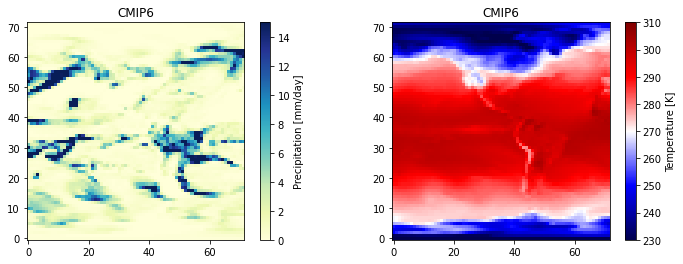

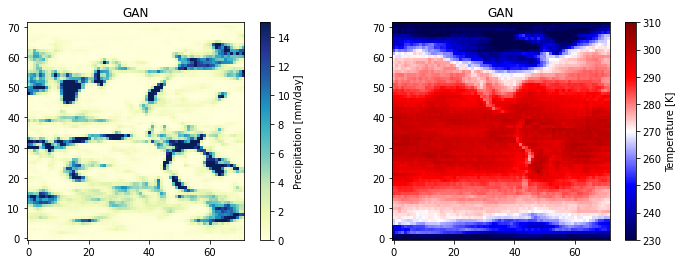

In [10]:
i = np.random.randint(100)
print(i)
plot_sample(target[i].cpu(), title='CMIP6')
plot_sample(gan[i].cpu(), title='GAN')

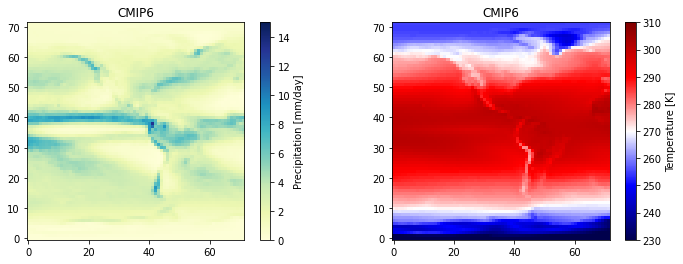

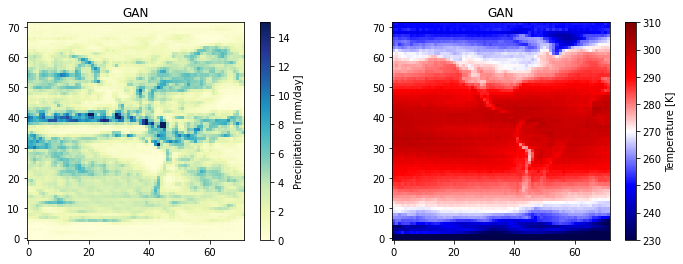

In [11]:
target_mean = target.mean(dim=0)
gan_mean = gan.mean(dim=0)
plot_sample(target_mean.cpu(), title='CMIP6')
plot_sample(gan_mean.cpu(), title='GAN')

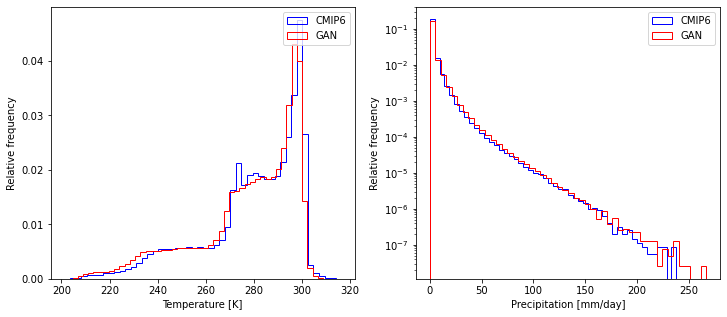

In [12]:
plot_histograms(gan, target)

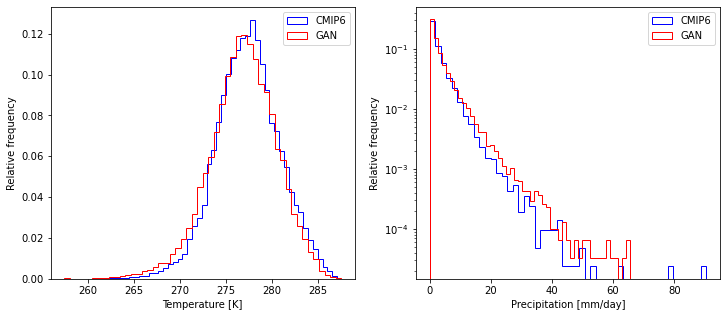

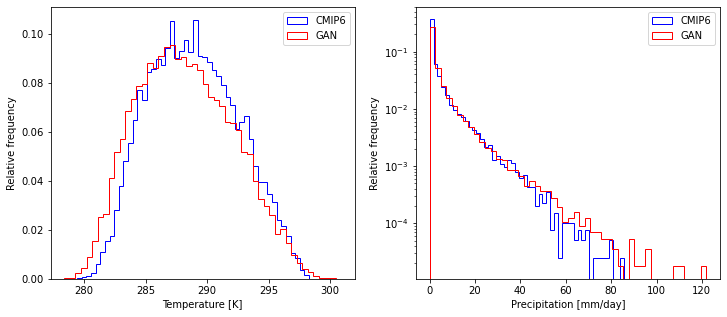

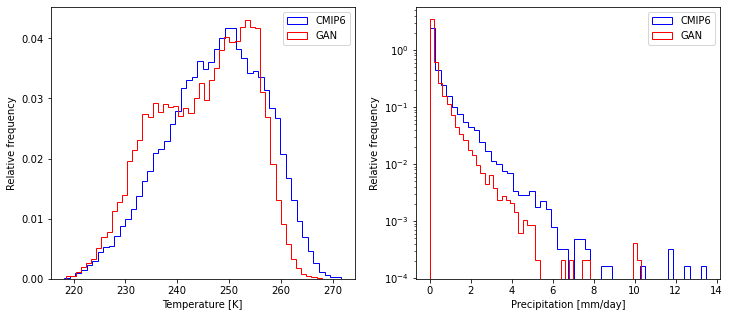

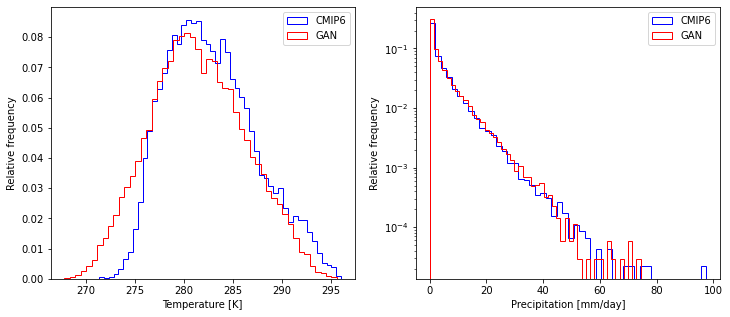

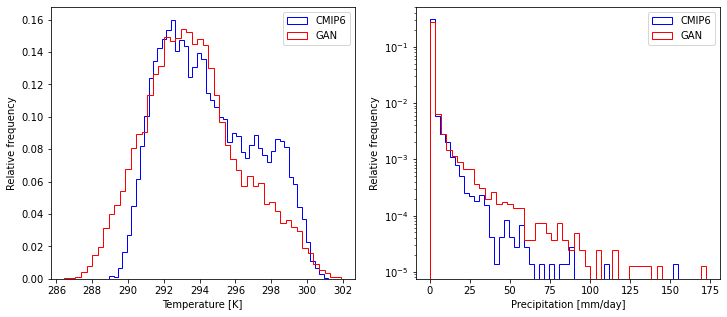

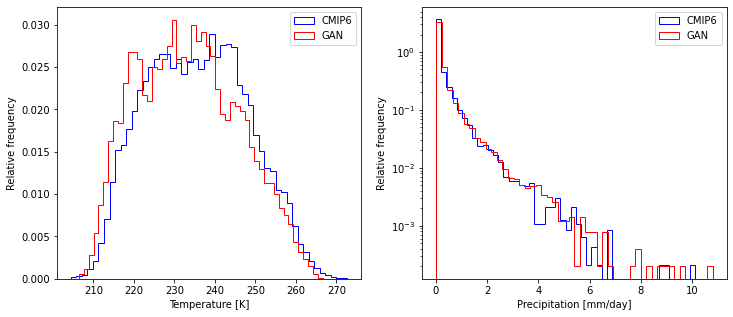

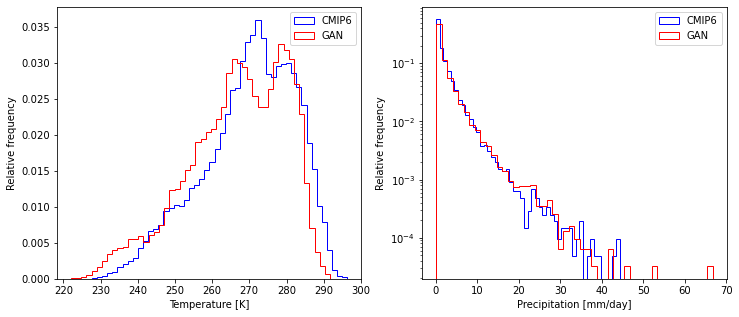

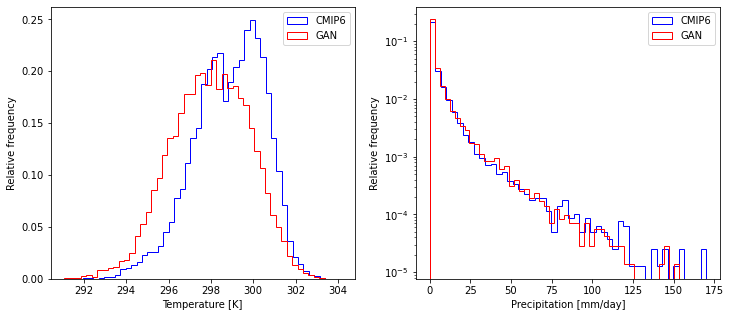

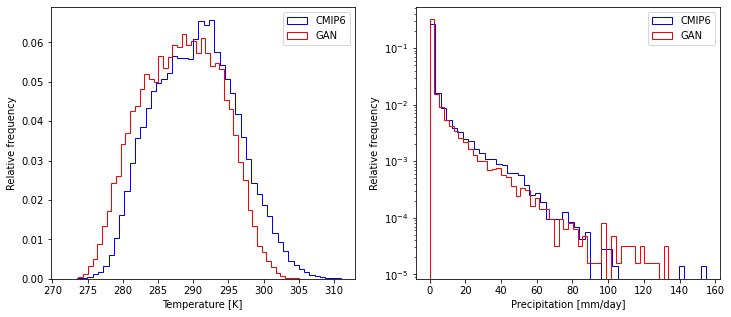

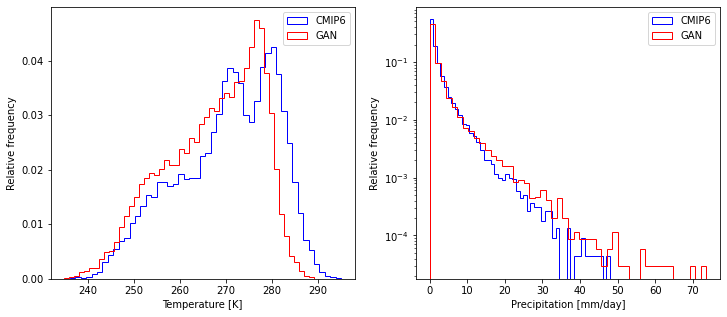

In [13]:
n_samples = 10
for s in range(n_samples):
    lat_idx = np.random.randint(2,70)
    lon_idx = np.random.randint(2,70)
    gan_data = gan[:,:,lat_idx-2:lat_idx+2,lon_idx-2:lon_idx+2]
    target_data = target[:,:,lat_idx-2:lat_idx+2,lon_idx-2:lon_idx+2]
    
    plot_histograms(gan_data, target_data)